# 【問題1】スクラッチを振り返る
ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。
それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。

- 重みを初期化する必要があった
- エポックのループが必要だった
- 各レイヤーの定義
- レイヤー（層）の構築
- フォワードプロパゲーションの実行
- 損失関数の定義
- lossの算出
- バックプロパゲーションの実行
- 重みの更新
- 評価指標の定義
- エポック終了ごとにvalのlossと評価指標の算出

データセットの用意

以前から使用しているIrisデータセットを使用します。以下のサンプルコードではIris.csvが同じ階層にある想定です。

目的変数はSpeciesですが、3種類ある中から以下の2種類のみを取り出して使用します。

Iris-versicolor

Iris-virginica

# 【問題2】スクラッチとTensorFlowの対応を考える
以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。

それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。

- 重みの初期化、　まずは重みの定義をしglobal_variables_initializerで初期化している
- エポックのループ、エポック分ループ回しているだけなのであまり変わらない
- 各レイヤーの定義とレイヤー層の構築、　データフローグラフを作っている
- フォワードプロパゲーションの実行とバックプロパゲーションの実行、　optimizerと損失関数を定義し、minimizeで損失関数を設定し、runで実行している。
- 損失関数の定義、データフローグラフの作成
- lossの算出、データフローグラフをrunで実行
- 重みの更新、variableで宣言された重みがoptimizerをrunすることで更新されていく
- 評価指標の定義、　データフローグラフの作成（runで実行）
- エポック終了ごとにvalのlossと評価指標の算出、lossと評価指標のデータフローグラフをrun

In [3]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 13.2121, val_loss : 24.4963, acc : 0.750, val_acc : 0.375
Epoch 1, loss : 18.1877, val_loss : 4.5707, acc : 0.500, val_acc : 0.750
Epoch 2, loss : 4.2584, val_loss : 1.0303, acc : 0.500, val_acc : 0.875
Epoch 3, loss : 0.0000, val_loss : 1.1173, acc : 1.000, val_acc : 0.812
Epoch 4, loss : 1.8176, val_loss : 2.2332, acc : 0.750, val_acc : 0.750
Epoch 5, loss : 0.0000, val_loss : 0.2718, acc : 1.000, val_acc : 0.938
Epoch 6, loss : 0.0000, val_loss : 1.7391, acc : 1.000, val_acc : 0.812
Epoch 7, loss : 0.0000, val_loss : 0.3918, acc : 1.000, val_acc : 0.938
Epoch 8, loss : 0.0005, val_loss : 5.0129, acc : 1.000, val_acc : 0.750
Epoch 9, loss : 0.0030, val_loss : 4.3243, acc : 1.000, val_acc : 0.688
test_acc : 0.800


# 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成

In [81]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを3値分類する
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
#y = y[:, np.newaxis]
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2

y = y.astype(np.int)[:, np.newaxis]

#ワンホット化
zero = np.zeros((y.shape[0], 3))
for i in range(len(y)):
    zero[i, y[i,0]] = 1
y = zero

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 20
num_epochs = 30

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = y.shape[1] ##クラス数を変更

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits)) ##softmaxバージョンへ変更
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

#softmax
pred = tf.nn.softmax(logits)

# 推定結果
correct_pred = tf.equal(tf.math.argmax(Y, axis=1), tf.math.argmax(pred, axis=1)) ##変更

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 94.0973, val_loss : 95.3749, acc : 0.312, val_acc : 0.292
Epoch 1, loss : 12.1740, val_loss : 9.6359, acc : 0.688, val_acc : 0.708
Epoch 2, loss : 30.8765, val_loss : 26.1545, acc : 0.375, val_acc : 0.417
Epoch 3, loss : 13.9444, val_loss : 12.8838, acc : 0.688, val_acc : 0.708
Epoch 4, loss : 7.7238, val_loss : 16.4116, acc : 0.688, val_acc : 0.625
Epoch 5, loss : 7.4639, val_loss : 9.3433, acc : 0.688, val_acc : 0.708
Epoch 6, loss : 2.4486, val_loss : 9.8662, acc : 0.812, val_acc : 0.667
Epoch 7, loss : 3.8442, val_loss : 6.5077, acc : 0.750, val_acc : 0.708
Epoch 8, loss : 0.6011, val_loss : 7.2369, acc : 0.938, val_acc : 0.708
Epoch 9, loss : 1.0719, val_loss : 3.8185, acc : 0.812, val_acc : 0.792
Epoch 10, loss : 0.0002, val_loss : 2.7001, acc : 1.000, val_acc : 0.708
Epoch 11, loss : 0.0485, val_loss : 2.4605, acc : 0.938, val_acc : 0.875
Epoch 12, loss : 0.0000, val_loss : 1.0285, acc : 1.000, val_acc : 0.875
Epoch 13, loss : 0.0000, val_loss : 1.0397, acc : 1.0

# 【問題4】House Pricesのモデルを作成
回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。

House Prices: Advanced Regression Techniques

この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。説明変数はさらに増やしても構いません。

分類問題と回帰問題の違いを考慮してください。

In [142]:
"""
TensorFlowで実装したニューラルネットワークを使いhousepriceデータセットでセールプライスを回帰
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# データセットの読み込み
dataset_path ="train.csv"
df = pd.read_csv(dataset_path)
y = df["SalePrice"]
X = df.loc[:,['GrLivArea', 'YearBuilt']]
y = np.array(y)
X = np.array(X)
y = np.log(y) #分布偏ってるのでlog
y = y.astype("f")[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
#標準化
sc = StandardScaler()
X_train = sc.fit_transform(X_train).astype("f")
X_val = sc.transform(X_val).astype("f")
X_test = sc.transform(X_test).astype("f")

# ハイパーパラメータの設定
learning_rate = 0.005
batch_size = 20
num_epochs = 30

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = y.shape[1] ##クラス数を変更

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.losses.mean_squared_error(labels=Y, predictions=logits)) ##mseバージョンへ変更tf.reduce_mean

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
#correct_pred = tf.equal(tf.math.argmax(Y, axis=1), tf.math.argmax(pred, axis=1)) 

correct_pred = tf.abs(Y - logits)

# 指標値計算
#accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
mean_absolute_error = tf.reduce_mean(correct_pred)
# variableの初期化
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_mae = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, mae = sess.run([loss_op, mean_absolute_error], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_mae += mae
        total_loss /= n_samples
        total_mae /= n_samples
        val_loss, val_mae = sess.run([loss_op, mean_absolute_error], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, mae : {:.3f}, val_mae : {:.3f}".format(epoch, loss, val_loss, mae, val_mae))
    test_mae = sess.run(mean_absolute_error, feed_dict={X: X_test, Y: y_test})
    print("test_mae : {:.3f}".format(test_mae))

/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  wa

Epoch 0, loss : 43.6934, val_loss : 42.5481, mae : 6.206, val_mae : 5.449
Epoch 1, loss : 13.4982, val_loss : 8.2916, mae : 2.647, val_mae : 2.219
Epoch 2, loss : 5.9669, val_loss : 4.0113, mae : 1.742, val_mae : 1.481
Epoch 3, loss : 3.1112, val_loss : 2.8104, mae : 1.317, val_mae : 1.255
Epoch 4, loss : 1.7569, val_loss : 2.2654, mae : 1.106, val_mae : 1.138
Epoch 5, loss : 1.1671, val_loss : 1.9618, mae : 0.943, val_mae : 1.058
Epoch 6, loss : 0.9623, val_loss : 1.7507, mae : 0.840, val_mae : 0.994
Epoch 7, loss : 0.9178, val_loss : 1.5650, mae : 0.798, val_mae : 0.939
Epoch 8, loss : 0.9006, val_loss : 1.4018, mae : 0.815, val_mae : 0.885
Epoch 9, loss : 0.8952, val_loss : 1.2383, mae : 0.814, val_mae : 0.831
Epoch 10, loss : 0.8679, val_loss : 1.0743, mae : 0.792, val_mae : 0.776
Epoch 11, loss : 0.8998, val_loss : 0.9732, mae : 0.793, val_mae : 0.733
Epoch 12, loss : 0.9377, val_loss : 0.9308, mae : 0.791, val_mae : 0.728
Epoch 13, loss : 0.9538, val_loss : 0.8997, mae : 0.800, v

In [134]:
with tf.Session() as sess:
    print(sess.run(aaa))

3511.8354


(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024227, 10.76766539, 11.0750885 , 11.38251162, 11.68993473,
        11.99735785, 12.30478096, 12.61220407, 12.91962719, 13.2270503 ,
        13.53447342]),
 <a list of 10 Patch objects>)

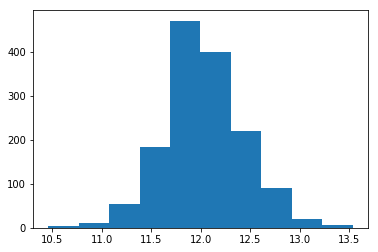

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y)

# 【問題5】MNISTのモデルを作成

ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。

3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。

スクラッチで実装したモデルの再現を目指してください。

In [ ]:
"""
TensorFlowで実装したニューラルネットワークを使いMNISTデータセットを分類する
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import input_data
# データセットの読み込み
#dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
#y = y[:, np.newaxis]
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2

y = y.astype(np.int)[:, np.newaxis]

#ワンホット化
zero = np.zeros((y.shape[0], 3))
for i in range(len(y)):
    zero[i, y[i,0]] = 1
y = zero

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 20
num_epochs = 30

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = y.shape[1] ##クラス数を変更

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits)) ##softmaxバージョンへ変更
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

#softmax
pred = tf.nn.softmax(logits)

# 推定結果
correct_pred = tf.equal(tf.math.argmax(Y, axis=1), tf.math.argmax(pred, axis=1)) ##変更

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

In [227]:
"""
TensorFlowで実装したニューラルネットワークを使いMNISTデータセットを分類する
２dconv２層
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
# データセットの読み込み
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train.images
y = mnist.train.labels
#X /= 255.0 されてたのでいらない
X = X.reshape(-1, 28,28,1) #フラットになってるのでreshape
X = X.astype("f")
y = y.astype("f")

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# ハイパーパラメータの設定
learning_rate = 0.001
lam = 0.000001
batch_size = 20
num_epochs = 20

n_hidden1 = 100
n_hidden2 = 50
height = X_train.shape[1]
width = X_train.shape[2]
channel = X_train.shape[3]
n_samples = X_train.shape[0]
n_classes = y.shape[1] ##クラス数を変更

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, height, width, channel])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

#Helper 関数
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# 重みとバイアスの宣言
weights = {
        'W_conv1': tf.Variable(tf.random_normal([5, 5, 1, 32])), #FH, FW, C, FN
        'W_conv2': tf.Variable(tf.random_normal([3, 3, 32, 64])), #FH, FW, C, FN
        'w1': tf.Variable(tf.random_normal([3136, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
biases = {
        'b_conv1': tf.Variable(tf.random_normal([32])),
        'b_conv2': tf.Variable(tf.random_normal([64])),
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

conv2d1 = conv2d(X, weights['W_conv1']) + biases['b_conv1']
conv2d1 = tf.nn.relu(conv2d1)
pool1 = max_pool_2x2(conv2d1) #14
conv2d2 = conv2d(pool1, weights['W_conv2']) + biases['b_conv2']
conv2d2 = tf.nn.relu(conv2d2)
pool2 = max_pool_2x2(conv2d2) #7
flat = tf.reshape(pool2, [-1, 7 * 7 * 64]) #3136

layer_1 = tf.add(tf.matmul(flat, weights['w1']), biases['b1'])
layer_1 = tf.nn.relu(layer_1)
layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
layer_2 = tf.nn.relu(layer_2)
logits = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である

# ネットワーク構造の読み込み                               
#logits = example_net(X)

#L2正規化
l2_losses = [tf.nn.l2_loss(w) for w in weights.values()]
l2_loss = lam * tf.add_n(l2_losses)
# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits)) + l2_loss ##L2loss追加
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

#softmax
pred = tf.nn.softmax(logits)

# 推定結果
correct_pred = tf.equal(tf.math.argmax(Y, axis=1), tf.math.argmax(pred, axis=1)) ##変更

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化 
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init) #sessionごとに初期化しないとだめ
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 0, loss : 242.3357, val_loss : 543.4160, acc : 0.950, val_acc : 0.883
Epoch 1, loss : 0.1470, val_loss : 275.0762, acc : 1.000, val_acc : 0.923
Epoch 2, loss : 0.1469, val_loss : 201.0357, acc : 1.000, val_acc : 0.940
Epoch 3, loss : 7.9361, val_loss : 148.0680, acc : 0.950, val_acc : 0.949
Epoch 4, loss : 0.1469, val_loss : 139.2605, acc : 1.000, val_acc : 0.946
Epoch 5, loss : 0.1469, val_loss : 104.9268, acc : 1.000, val_acc : 0.955
Epoch 6, loss : 0.1468, val_loss : 99.6007, acc : 1.000, val_acc : 0.959
Epoch 7, loss : 0.1466, val_loss : 78.5174, acc : 1.000, val_acc : 0.965
Epoch 8, loss : 0.1461, val_loss : 69.9427, acc : 1.000, val_acc : 0.967
Epoch 9, loss : 0.1454, val_loss : 72.0735, acc : 1.000, val_acc : 0.965
Epoch 10, loss : 0.1443, val_loss : 60.1205, acc : 1.000, val_acc : 

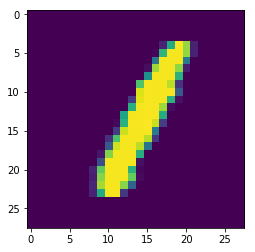

In [182]:
plt.imshow(X_train[50])

In [215]:
l2_loss = tf.nn.l2_loss(weights[""]) 
with tf.Session() as sess:
    sess.run(init) 
    print(sess.run(l2_loss))

2532.6375


In [224]:
lam = 0.0001
l2_losses = [tf.nn.l2_loss(w) for w in weights.values()]
l2_loss = lam * tf.add_n(l2_losses)
with tf.Session() as sess:
    sess.run(init) 
    print(sess.run(l2_losses))

[422.5571, 9297.575, 156878.53, 2480.5413, 273.349]
